# DL Data and Result Analysis

**Files that are needed in this notebook:**

In [4]:
allprob_filename = './out/allprob_iter_64000.npy'
allans_filename = './data/allans.npy'
target_relations_training_filename = './data/train_y.npy'
relation2id_filename = './origin_data/relation2id.txt'
testdata_filename = './origin_data/test.txt'

Contents:
0. Overall Average Precision Score
1. Relation Distributions:  
i. Relation Distribution across Test dataset  
ii. Relation Distribution across Training dataset  
2. Precision and Recall for each relations
3. Probability distributions the model assigns to each example

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
# Verify consistency:
allprob = np.load(allprob_filename)
allans = np.load(allans_filename)
probs = np.reshape(allprob,(-1,90))
ans   = np.reshape(allans, (-1,90)) # 90 positions to represent 91 relations, all-zero for NA.
print(probs.shape)
print(ans.shape)

(13265, 90)
(13265, 90)


## 1. Overall Average Precision Score:

In [7]:
from sklearn.metrics import average_precision_score
average_precision_score(allans, allprob)

0.7522063100113775

## 2. Relation Distributions:
Relations is represented by one-hot encoding.  
0 means NA.  
7 means height.  
8 means position.  
10 means youthclubs.  
**Neither training data nor testing data includes complete list of relations.**
### 2.1 Relation Distribution across Test dataset:

defaultdict(<class 'int'>, {7: 4136, 12: 1468, 1: 1272, 39: 115, 38: 119, 2: 858, 50: 58, 22: 99, 51: 867, 66: 232, 55: 184, 56: 194, 20: 176, 58: 129, 6: 792, 80: 304, 75: 124, 77: 28, 65: 10, 78: 31, 28: 535, 44: 3, 64: 343, 43: 234, 84: 18, 24: 25, 88: 6, 18: 319, 83: 229, 63: 16, 42: 136, 25: 105, 37: 65, 81: 1, 40: 4, 52: 69, 36: 2, 76: 92, 8: 12, 79: 28, 23: 2, 74: 67, 35: 1, 10: 2, 89: 1, 85: 2, 4: 1, 62: 1})


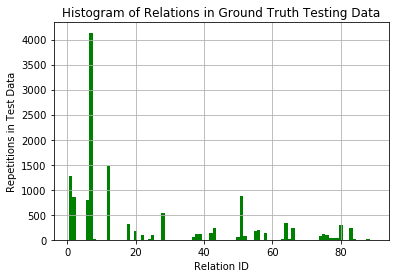

In [8]:
ans_distro = defaultdict(int)
for a in [np.where(r==1)[0] for r in ans]:
    for r_id in a:
        ans_distro[r_id] += 1
        
print(ans_distro)

plt.bar(list(ans_distro.keys()), ans_distro.values(), width=1,color='g')
plt.title('Histogram of Relations in Ground Truth Testing Data')
plt.xlabel('Relation ID')
plt.ylabel('Repetitions in Test Data')
plt.grid(True)
plt.show()

### 2.2 Relation Distribution across Training Dataset:

defaultdict(<class 'int'>, {8: 31659, 13: 11675, 2: 10102, 51: 437, 52: 7068, 53: 465, 29: 4305, 65: 2544, 85: 214, 84: 1692, 3: 7424, 81: 2762, 7: 6394, 44: 2026, 80: 209, 23: 865, 19: 2519, 56: 1257, 57: 1328, 21: 1177, 59: 875, 43: 1061, 26: 1122, 76: 990, 25: 187, 75: 607, 67: 1824, 40: 1032, 39: 1042, 38: 647, 77: 646, 79: 286, 64: 244, 41: 36, 78: 223, 66: 89, 9: 107, 36: 24, 50: 9, 45: 37, 34: 2, 35: 1, 24: 3, 82: 5, 12: 1, 28: 2, 11: 1, 48: 1, 49: 2, 58: 3, 37: 16, 89: 2, 86: 20, 5: 4, 10: 1, 17: 2, 62: 1, 22: 1, 27: 2, 63: 1, 46: 1})


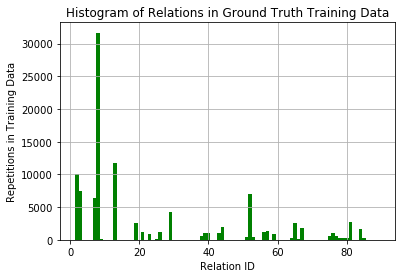

In [9]:
train_y = np.load(target_relations_training_filename)
train_distro = defaultdict(int)
for a in [np.where(r==1)[0] for r in train_y]:
    for r_id in a:
        train_distro[r_id] += 1
        
print(train_distro)

plt.bar(list(train_distro.keys()), train_distro.values(), width=1,color='g')
plt.title('Histogram of Relations in Ground Truth Training Data')
plt.xlabel('Relation ID')
plt.ylabel('Repetitions in Training Data')
plt.grid(True)
plt.show()

## 3. Precision and Recall for each relations
In the test dataset, for each relationship R:  
- A = number of correctly matched R's from allprobs to allans.
- B = number of R's that has not been matched by allprobs.
- C = number of R's that given by allprobs but actually are not in allans.

In [10]:
# reading relation2id.txt into dictionary
relation2id = {}
relationfile = open(relation2id_filename,'r')
while True:
    content = relationfile.readline()
    if content == '':
        break
    content = content.strip().split()
    relation2id[content[0]] = int(content[1])
relationfile.close()
rid2relation = dict((v,k) for k,v in relation2id.items())

In [11]:
# Softmax over probs (from allprobs):
r_probs = []
for p in probs:
    r_probs.append(np.argmax(p))

In [12]:
# Convert one-plus-hot encoded ans to relation-IDs list
ans_rs = list()
for a in [np.where(r==1)[0] for r in ans]:
    current_relations = list()
    for r_id in a:
        current_relations.append(r_id)
    ans_rs.append(current_relations)

In [13]:
# Now we have r_probs, ans_rs, and relation2id, we can calculate PR for each relations:
AnB = ans_distro
AnC = defaultdict(int)
for a in r_probs:
    AnC[a] += 1
    
A = defaultdict(int)
for i in range(len(r_probs)):
    predict = r_probs[i]
    truth   = ans_rs[i]
    if predict in truth:
        A[predict] += 1

# Verify that A is always lessOrEqual to both AnB and AnC for each rid
'''
for rid in A:
    anb = AnB[i]
    anc = AnC[i]
    a   = A[i]
    if not (a <= anb and a <= anc):
        print('error!')
print('All TP, FP, TN, FN has been calculated and verified for each realtion...')
'''

"\nfor rid in A:\n    anb = AnB[i]\n    anc = AnC[i]\n    a   = A[i]\n    if not (a <= anb and a <= anc):\n        print('error!')\nprint('All TP, FP, TN, FN has been calculated and verified for each realtion...')\n"

In [14]:
PR_Result = {}
for rid in A:
    anb = AnB[rid]
    anc = AnC[rid]
    a   = A[rid]
    precision = a/anc
    recall    = a/anb
    f1        = 2*(precision*recall)/(precision+recall)
    PR_Result[rid] = [precision, recall, f1]

In [15]:
PR_Result

{1: [0.8421450151057401, 0.8765723270440252, 0.8590138674884438],
 2: [0.8834498834498834, 0.8834498834498834, 0.8834498834498834],
 6: [0.3032128514056225, 0.19065656565656566, 0.23410852713178298],
 7: [0.7709190672153635, 0.8152804642166345, 0.7924794359576968],
 12: [0.47135955831608006, 0.4652588555858311, 0.46828933836133013],
 18: [0.7904761904761904, 0.780564263322884, 0.7854889589905364],
 20: [0.3395061728395062, 0.3125, 0.3254437869822485],
 22: [0.2641509433962264, 0.2828282828282828, 0.2731707317073171],
 24: [0.125, 0.04, 0.06060606060606061],
 25: [0.3, 0.37142857142857144, 0.33191489361702126],
 28: [0.27920792079207923, 0.2635514018691589, 0.27115384615384613],
 37: [0.26436781609195403, 0.35384615384615387, 0.3026315789473684],
 38: [0.49572649572649574, 0.48739495798319327, 0.4915254237288135],
 39: [0.45569620253164556, 0.3130434782608696, 0.37113402061855677],
 42: [0.6068376068376068, 0.5220588235294118, 0.5612648221343873],
 43: [0.2261904761904762, 0.24358974358

In [16]:
np.save('./analytics/PR_Relations.npy',PR_Result)

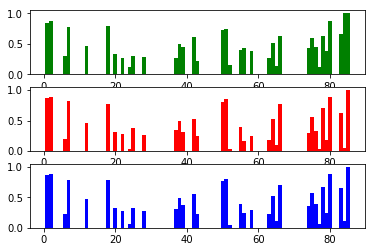

In [17]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

keys = np.fromiter(iter(PR_Result.keys()), dtype=int)
precision = []
recall = []
f1 = []
for i in PR_Result:
    precision.append(PR_Result[i][0])
    recall.append(PR_Result[i][1])
    f1.append(PR_Result[i][2])
precision = np.asarray(precision, dtype=np.float32)
recall = np.asarray(recall, dtype=np.float32)
f1 = np.asarray(f1, dtype=np.float32)

plt.figure(1)
plt.subplot(311)
plt.bar(keys, precision, width=1,color='g')

plt.subplot(312)
plt.bar(keys, recall, width=1,color='r')

plt.subplot(313)
plt.bar(keys, f1, width=1,color='b')

plt.show()

## 4. Probability distributions the model assigns to each example

In [18]:
probs 

array([[  1.56337010e-05,   1.94516600e-04,   1.58340367e-06, ...,
          1.56337010e-05,   4.15822287e-04,   1.56337010e-05],
       [  9.85509541e-09,   2.37885569e-08,   1.54357558e-08, ...,
          9.85509541e-09,   9.16592455e-08,   9.85509541e-09],
       [  5.70405234e-07,   1.24763808e-08,   6.15619797e-07, ...,
          5.70405234e-07,   4.57385937e-07,   5.70405234e-07],
       ..., 
       [  8.77891715e-09,   1.07028986e-09,   3.71956972e-08, ...,
          8.77891715e-09,   1.16642029e-09,   8.77891715e-09],
       [  1.59368287e-08,   2.84193584e-06,   2.93459190e-09, ...,
          1.59368287e-08,   3.30894956e-08,   1.59368287e-08],
       [  2.54215252e-07,   9.41269900e-05,   1.77742766e-06, ...,
          2.54215252e-07,   4.58095229e-07,   2.54215252e-07]], dtype=float32)

In [19]:
np.save('./analytics/ProbDistro_TestData.npy',probs)

## 5. Add Biography Index for Global Constraint on Relations

# TO-DO:
!!!Mistake!!!: The relation2id.txt file is generated with the training dataset, which does not consider the test dataset! Missing relations in the testing.    
Currently affacted relation class is 'shoots', which appear in testing dataset, but not in traing relation2id.txt file.

In [20]:
bio2id = {} # unique BID for each biography
bid_index = 0
testfile_dict = {} # testfile_row: [bio_name, r, sentence]
testfile_row = 0

testfile = open(testdata_filename,'r')
#
# One row in test.txt looks like:
# ['SH', 'SH', 'renato_campos', 'defender', 'position', 
#  'renato campos born september 5 , 1980 is a retired angolan football player .he has played for angola national team . ###END###']
#
while True:
    content = testfile.readline()
    if content == '':
        break
    content = content.strip().split('\t')
    bio_name = content[2]
    r = content[4]
    bio_sentence = content[5]
    testfile_dict[testfile_row] = [bio_name, r, bio_sentence]
    testfile_row += 1
    if bio_name not in bio2id.keys():
        bio2id[bio_name] = bid_index
        bid_index += 1

how_many_missing_relations = 0
testfile_dict2 = {}    # row: [bid, rid, sentence]    
for arow in testfile_dict:
    x = testfile_dict[arow]
    bid = bio2id[x[0]]
    if x[1] not in relation2id.keys():
        print(x[0]+' '+x[1])
        how_many_missing_relations += 1
    else:
        rid = relation2id[x[1]]
        testfile_dict2[arow] = [bid,rid-1,x[2]]

if how_many_missing_relations != 0:
    print('Warning! There are '+str(how_many_missing_relations)+' relations missed from the test dataset! Check out relation2id.txt file!')

In [21]:
ans_i = 0
i = 0

bid_rid_prob_sentence = []
bid_rid_prob_sentence_np = np.empty


while i < len(testfile_dict2):
    if (testfile_dict2[i][1]) in ans_rs[ans_i]:
        bid = testfile_dict2[i][0]
        rid = testfile_dict2[i][1]
        prob = probs[ans_i]
        sentence = testfile_dict2[i][2]
        bid_rid_prob_sentence.append([bid,rid,prob,sentence])
        ans_i += 1
        i += 1
    elif len(ans_rs[ans_i]) == 0:
        ans_i += 1
    else:
        i += 1

In [22]:
len(bid_rid_prob_sentence)

13147

In [23]:
len(ans_rs)

13265

In [24]:
empty_in_ans_rs = 0
for i in ans_rs:
    if len(i) == 0:
        empty_in_ans_rs += 1
print('There are empty groud-truth relation in ans_rs: ' + str(empty_in_ans_rs))
print(str(len(ans_rs)) + ' - ' + str(len(bid_rid_prob_sentence)) + ' = ' + str(len(ans_rs) - len(bid_rid_prob_sentence)))

There are empty groud-truth relation in ans_rs: 118
13265 - 13147 = 118


### Result available for IR project
- *bid_rid_prob_sentence* is an array of array.  
- Each entry is also an array of length **4**.
- **[biography_id, relation_id, predicted_probability_distribution, original_sent_sentence]**

#### Example:

In [25]:
bid_rid_prob_sentence[0]

[0, 7, array([  1.56337010e-05,   1.94516600e-04,   1.58340367e-06,
          1.56337010e-05,   1.66337213e-05,   1.56337010e-05,
          7.30791613e-02,   8.32996726e-01,   6.84211118e-05,
          1.32623376e-04,   5.85397265e-06,   4.04730818e-05,
          3.45547055e-03,   1.56337010e-05,   1.56337010e-05,
          1.56337010e-05,   1.84580449e-06,   1.56337010e-05,
          8.31719808e-06,   1.56337010e-05,   3.04376590e-04,
          1.04517203e-05,   1.20204361e-03,   4.10378161e-05,
          3.16219492e-04,   4.16630059e-02,   1.28215779e-05,
          3.19493824e-06,   2.60710418e-02,   1.56337010e-05,
          1.56337010e-05,   1.56337010e-05,   1.56337010e-05,
          9.52556547e-07,   6.75233514e-06,   2.33430592e-06,
          9.45519241e-06,   1.25460676e-03,   1.10694685e-03,
          2.38832043e-04,   8.32763908e-05,   1.56337010e-05,
          5.25011004e-08,   5.89197189e-05,   3.02585636e-06,
          6.12477379e-06,   1.56337010e-05,   1.02071535e-05,
  

#### For example, when bid = 8, there are two entry from the test dataset:

In [26]:
bid = 8
for i in bid_rid_prob_sentence:
    if i[0] == bid:
        print(str(i[0])+"\t"+str(i[1])+"\t"+i[3])

8	7	leandro `` chichi '' chichizola ; born 27 march 1990 is an argentine footballer who plays as a goalkeeper for italian serie b club spezia calcio . ###END###
8	12	leandro `` chichi '' chichizola ; born 27 march 1990 is an argentine footballer who plays as a goalkeeper for italian serie b club spezia calcio . ###END###


#### Write result to file:

In [46]:
# Use | as splitter:
bid_rid_p_s = open("./bid_rid_p_s.csv",'w') 
for entry in bid_rid_prob_sentence:
    bid = entry[0]
    rid = entry[1]
    prob = entry[2]
    sen = entry[3]
    bid_rid_p_s.write(str(bid))
    bid_rid_p_s.write('|')
    bid_rid_p_s.write(str(rid))
    bid_rid_p_s.write('|')
    bid_rid_p_s.write(np.array_str(prob, max_line_width=2000))
    bid_rid_p_s.write('|')
    bid_rid_p_s.write(sen)
    bid_rid_p_s.write('\n')
    
bid_rid_p_s.close()